# Part Combination Space Exploration

This is a notebook developed to leverage the new SysML v2 semantics for nested features and instantiation of models to generate instances of M1 system models as feedstock for analysis pipelines.

In [1]:
import requests
import getpass
import math

from __future__ import print_function

import time
import sysml_v2_api_client
from sysml_v2_api_client.rest import ApiException
from pprint import pprint

import json
import networkx as NX

import random
import copy

# Configure API Server Connection

In [2]:
sysml_api_base_url = 'http://sysml2-sst.intercax.com:9000'

## Activate APIs

Connect the API classes to the server

In [3]:
configuration = sysml_v2_api_client.Configuration(
    host = sysml_api_base_url
)

projects_api_instance = None

with sysml_v2_api_client.ApiClient(configuration) as api_client:
    # Create an instance of the API class
    project_api_instance = sysml_v2_api_client.ProjectApi(api_client)
    
commits_api_instance = None

with sysml_v2_api_client.ApiClient(configuration) as api_client:
    # Create an instance of the API class
    commits_api_instance = sysml_v2_api_client.CommitApi(api_client)
    
elements_api_instance = None

with sysml_v2_api_client.ApiClient(configuration) as api_client:
    # Create an instance of the API class
    elements_api_instance = sysml_v2_api_client.ElementApi(api_client)

## Pull down commits and elements catalogs

With the API handles, use the pre-built methods to get lists of commits and elements.

In [4]:
project_api_instance

In [5]:
kerbal_proj = [my_proj for my_proj in project_api_instance.get_projects() if my_proj.name.find('Kerbal') > -1][5]
kerbal_proj

{'id': '2886e8d8-ac30-4eff-bb6d-7b0374c0221f',
 'name': 'Kerbal Sat Feb 20 14:05:18 UTC 2021',
 'type': 'Project'}

In [6]:
try:
    # Get commits by project
    commits_response = commits_api_instance.get_commits_by_project(kerbal_proj.id)
    pprint(commits_response)
except ApiException as e:
    print("Exception when calling CommitApi->get_commits_by_project: %s\n" % e)

[{'change': None,
 'containing_project': {'id': '2886e8d8-ac30-4eff-bb6d-7b0374c0221f'},
 'id': '97ac5509-3d69-4638-98c8-548d92c77d78',
 'previous_commit': None,
 'type': 'Commit'}]


In [7]:
elements = []

try:
    # Get commits by project
    elements = elements_api_instance.get_elements_by_project_commit(kerbal_proj.id, commits_response[0].id)
except ApiException as e:
    print("Exception when calling ElementApi->get_elements_by_project_commit: %s\n" % e)

In [8]:
len(elements)

100

In [9]:
pprint(elements[0])

{'id': '005e77f7-9600-4b89-ac1b-9274377e6599',
 'identifier': '005e77f7-9600-4b89-ac1b-9274377e6599',
 'type': 'PartDefinition'}


# Gather Element Data

Since the generated API doesn't have much detail for elements, need to do this more hands-on.

Not elegant below to just have a larger page size, should implement paging later on.

In [10]:
elements_url = (sysml_api_base_url +
                '/projects/{0}/commits/{1}/elements?page[size]=2000').format(kerbal_proj.id, commits_response[0].id)

In [11]:
elements_url

'http://sysml2-sst.intercax.com:9000/projects/2886e8d8-ac30-4eff-bb6d-7b0374c0221f/commits/97ac5509-3d69-4638-98c8-548d92c77d78/elements?page[size]=2000'

In [12]:
elements_response = requests.get(
    elements_url
)

In [13]:
elements_data = elements_response.json()

Split the elements into relationships and non-relationships. This will let us work with graph representations and a graph understanding of the underlying model.

In [14]:
len(elements_data)

385

In [15]:
non_relations = [non_relation for non_relation in elements_data if not 'relatedElement' in non_relation]

In [16]:
relations = [relation for relation in elements_data if 'relatedElement' in relation]

In [17]:
len(non_relations)

158

In [18]:
len(relations)

227

In [19]:
['{0} : {1}'.format(nr['name'], nr['@type']) for nr in non_relations]

['Rocket : PartDefinition',
 'None : SourceEnd',
 'None : LiteralReal',
 'Specific Impulse : AttributeUsage',
 'FL-T100 Fuel Tank : PartDefinition',
 'Kerbal Rocket Part : PartDefinition',
 'None : LiteralInteger',
 'Staging Chart : StateDefinition',
 'transitionLink : Feature',
 'None : AcceptActionUsage',
 'Liquid Engine : PartDefinition',
 'None : LiteralInteger',
 'Burnout : StateUsage',
 'FL-T200 Fuel Tank : PartDefinition',
 'None : Feature',
 'Full Mass : AttributeUsage',
 'Full Mass : AttributeUsage',
 'RT-5 "Flea" Solid Fuel Booster : PartDefinition',
 '$result : Feature',
 'None : Feature',
 'None : Feature',
 'None : TransitionUsage',
 'Solid Booster : PartDefinition',
 'Empty Mass : AttributeUsage',
 'None : LiteralReal',
 'Mass : AttributeUsage',
 'Empty Mass : AttributeUsage',
 'None : LiteralReal',
 'Second Stage : StateUsage',
 'None : ItemFeature',
 'Mk1 Command Pod : PartDefinition',
 'Torque : AttributeUsage',
 'None : LiteralInteger',
 '$result : Feature',
 'Fuel Ta

# Connect to Semantic Libraries

The real work comes in the connection to M1 and then its interpretation at M0. Start processing the model here.

In [20]:
id_memo_dict = {}

In [21]:
def get_name_by_id(id_to_check):
    if id_to_check in id_memo_dict:
        return id_memo_dict[id_to_check]['name']
    
    return id_to_check

## Part Definitions and the Usage Features

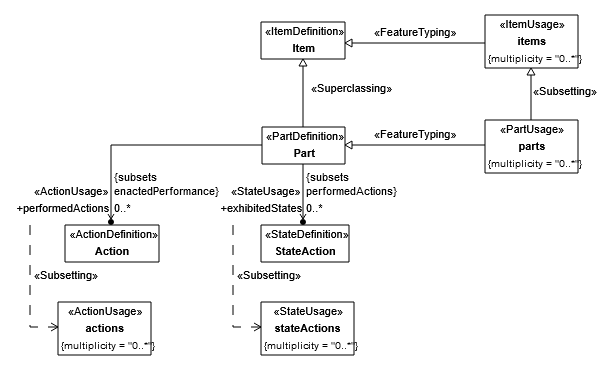

The "parts" feature will always be typed by Part, any additional features applied to a PartDefinition will subset parts.

In [22]:
part_defs = [part_def for part_def in non_relations if part_def['@type'] == 'PartDefinition']

In [23]:
["{0}".format(part_def['name']) for part_def in part_defs]

['Rocket',
 'FL-T100 Fuel Tank',
 'Kerbal Rocket Part',
 'Liquid Engine',
 'FL-T200 Fuel Tank',
 'RT-5 "Flea" Solid Fuel Booster',
 'Solid Booster',
 'Mk1 Command Pod',
 'Fuel Tank Section',
 'LV-T45 "Swivel" Liquid Fuel Engine',
 'Pod',
 'Rocket Stage',
 'Solid Stage',
 'RT-10 "Hammer" Solid Fuel Booster',
 'Liquid Stage',
 'Parachute']

In [24]:
for part_def in part_defs:
    id_memo_dict.update({part_def['@id']: part_def})

## Subclassing Graph

Trace the path from the most specialized PartDefinitions back to the library. Pack the results into a graph for later computations on going up and down the specialization tree.

In [25]:
superclasses = [sup for sup in relations if sup['@type'] == 'Superclassing']

In [26]:
len(superclasses)

12

In [27]:
superclassing_graph = NX.DiGraph()
subclassing_graph = NX.DiGraph()

In [28]:
for sup in superclasses:
    if sup['specific']['@id'] in id_memo_dict:
        subclassing_graph.add_edge(sup['general']['@id'], sup['specific']['@id'])
        superclassing_graph.add_edge(sup['specific']['@id'], sup['general']['@id'])

In [29]:
['{0} :> {1}'.format(
    get_name_by_id(sup['subclass']['@id']), get_name_by_id(sup['superclass']['@id'])
) for sup in superclasses if sup['subclass']['@id'] in id_memo_dict]

['Mk1 Command Pod :> Pod',
 'Liquid Stage :> Rocket Stage',
 'FL-T200 Fuel Tank :> Fuel Tank Section',
 'RT-5 "Flea" Solid Fuel Booster :> Solid Booster',
 'FL-T100 Fuel Tank :> Fuel Tank Section',
 'Pod :> Kerbal Rocket Part',
 'RT-10 "Hammer" Solid Fuel Booster :> Solid Booster',
 'Solid Stage :> Rocket Stage',
 'LV-T45 "Swivel" Liquid Fuel Engine :> Liquid Engine',
 'Parachute :> Kerbal Rocket Part',
 'Fuel Tank Section :> Kerbal Rocket Part']

Draw the superclassing graph.

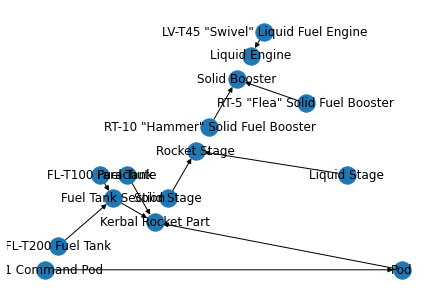

In [30]:
superclassing_graph_labels = {}
for node in superclassing_graph.nodes():
    superclassing_graph_labels.update({node: get_name_by_id(node)})
    
NX.draw_planar(superclassing_graph, labels=superclassing_graph_labels)

## PartUsages

Inspect the features of the part definitions that should go into the features list.

In [31]:
part_uses = [part_use for part_use in non_relations if part_use['@type'] == 'PartUsage']
for part_use in part_uses:
    id_memo_dict.update({part_use['@id']: part_use})

In [32]:
len(part_uses)

4

In [33]:
[get_name_by_id(part_use['@id']) for part_use in part_uses]

['stages', 'tanks', 'boosters', 'engines']

Look for FeatureMemberships and TypeFeaturings to see where the features belong.

In [34]:
feature_members = [feature_member for feature_member in relations if feature_member['@type'] == 'FeatureMembership']
type_features = [type_feature for type_feature in relations if type_feature['@type'] == 'TypeFeaturings']

In [35]:
len(feature_members)

58

In [36]:
len(type_features)

0

In [37]:
part_featuring_graph = NX.DiGraph()

In [38]:
for fm in feature_members:
    if fm['memberElement']['@id'] in id_memo_dict:
        if id_memo_dict[fm['memberElement']['@id']]['@type'] == 'PartUsage':
            part_featuring_graph.add_edge(fm['memberElement']['@id'], fm['owningType']['@id'])

In [39]:
[part_featuring_graph.in_degree(node) for node in part_featuring_graph.nodes]

[0, 1, 0, 2, 0, 0, 1]

In [40]:
['{0} is a member of {1}'.format(
    get_name_by_id(fm['memberElement']['@id']), get_name_by_id(fm['owningType']['@id'])
) for fm in feature_members if fm['memberElement']['@id'] in id_memo_dict]

['stages is a member of Rocket',
 'tanks is a member of Liquid Stage',
 'engines is a member of Liquid Stage',
 'boosters is a member of Solid Stage']

Draw the parts featuring graph.

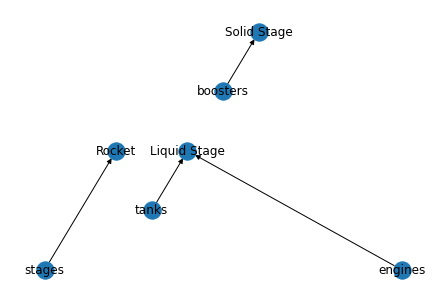

In [41]:
part_featuring_graph_labels = {}
for node in part_featuring_graph.nodes():
    part_featuring_graph_labels.update({node: get_name_by_id(node)})
    
NX.draw_planar(part_featuring_graph, labels=part_featuring_graph_labels)

Collect multiplicities.

In [42]:
mults = [mult for mult in non_relations if mult['@type'] == 'MultiplicityRange']
integers = [integer for integer in non_relations if integer['@type'] == 'LiteralInteger']

for mult in mults:
    id_memo_dict.update({mult['@id']: mult})
    
for integer in integers:
    id_memo_dict.update({integer['@id']: integer})

In [43]:
mult_strings = []
for mult in mults:
    mult_strings.append('[{0}..{1}]'.format(
        id_memo_dict[mult['lowerBound']['@id']]['value'],
        id_memo_dict[mult['upperBound']['@id']]['value']))

In [44]:
mult_strings

['[0..30]', '[0..8]', '[0..8]', '[1..5]']

In [45]:
def feature_lower_multiplicity(feature):
    if feature['multiplicity'] is not None:
        if '@id' in feature['multiplicity']:
            mult = id_memo_dict[feature['multiplicity']['@id']]
            if '@id' in mult['lowerBound']:
                return id_memo_dict[mult['lowerBound']['@id']]['value']
        
    return 1

In [46]:
def feature_upper_multiplicity(feature):
    if feature['multiplicity'] is not None:
        if '@id' in feature['multiplicity']:
            mult = id_memo_dict[feature['multiplicity']['@id']]
            if '@id' in mult['upperBound']:
                return id_memo_dict[mult['upperBound']['@id']]['value']
        
    return 1

In [47]:
['{0} has multiplicity {1}..{2}'.format(
    part_use['name'], feature_lower_multiplicity(part_use), feature_upper_multiplicity(part_use)
) for part_use in part_uses]

['stages has multiplicity 1..5',
 'tanks has multiplicity 0..30',
 'boosters has multiplicity 0..8',
 'engines has multiplicity 0..8']

Get feature types.

In [48]:
feature_types = [feature_type for feature_type in relations if feature_type['@type'] == 'FeatureTyping']

In [49]:
def get_feature_type_name(feature):
    if len(feature['type']) > 0:
        return get_name_by_id(feature['type'][0]['@id'])
    else:
        return 'Part'

In [50]:
['{0} : {1}'.format(
    get_name_by_id(ft['typedFeature']['@id']), get_name_by_id(ft['type']['@id'])
) for ft in feature_types if ft['typedFeature']['@id'] in id_memo_dict]

['engines : Liquid Engine',
 'tanks : Fuel Tank Section',
 'boosters : Solid Booster',
 'stages : Rocket Stage']

# Generate Instances

With the base semantic model in hand, begin to apply the rules to generate our system alternatives.

## Find number of instances for feature last positions

In SysML, the default type is PartDefinition, which is a Classifier, meaning the minimal interpretation of length one (the specific instance). Nesting parts then have an interpretation as expected by systems engineers, namely that the instances "stack" in order to provide a navigation from top-level assembly to leaf component.

In [51]:
['{0} needs {1} instances of type {2}'.format(
    part_use['name'], feature_upper_multiplicity(part_use), get_feature_type_name(part_use)
) for part_use in part_uses]

['stages needs 5 instances of type Rocket Stage',
 'tanks needs 30 instances of type Fuel Tank Section',
 'boosters needs 8 instances of type Solid Booster',
 'engines needs 8 instances of type Liquid Engine']

Automatically shorten names so that sequences remain readable when printed.

In [52]:
shorten_pre_bake = {
    'RT-10 "Hammer" Solid Fuel Booster': "RT-10",
    'RT-5 "Flea" Solid Fuel Booster': "RT-5",
    'LV-T45 "Swivel" Liquid Fuel Engine': "LV-T45",
    'FL-T100 Fuel Tank': "FL-T100",
    'FL-T200 Fuel Tank': "FL-T200"
}

In [53]:
def shorten_name(name):
    short_name = ''
    if len(name) > 5:
        if shorten_pre_bake is not None:
            if name in shorten_pre_bake:
                return shorten_pre_bake[name]
        space_place = name.find(' ')
        if space_place > -1:
            short_name = short_name + name[0]
            short_name = short_name + name[space_place + 1]
            next_space = name.find(' ', space_place + 1)
            while next_space > -1:
                short_name = short_name + name[next_space + 1]
                next_space = name.find(' ', next_space + 1)
            return short_name
    return name

In [54]:
class Instance():
    def __init__(self, name, index):
        self.name = shorten_name(name) + '#' + str(index)
        
    def __repr__(self):
        return self.name

In [55]:
multiplicity_dict = {}

for part_use in part_uses:
    type_name = get_feature_type_name(part_use)
    if type_name in multiplicity_dict:
        old_val = multiplicity_dict[part_use]
        multiplicity_dict.update({type_name: old_val + feature_upper_multiplicity(part_use)})
    else:
        multiplicity_dict.update({type_name: feature_upper_multiplicity(part_use)})

In [56]:
multiplicity_dict

{'Rocket Stage': 5,
 'Fuel Tank Section': 30,
 'Solid Booster': 8,
 'Liquid Engine': 8}

## Determine the size of the universe of instances needed for creating alternatives

Use feature membership together with multiplicity to decide how many individuals are needed.

### Building the banded graph

Build up a graph with the SysML v1 banded style of part-type-part-type (with superclassing).

In [57]:
banded_feature_graph = NX.DiGraph()

In [58]:
for fm in feature_members:
    if fm['memberElement']['@id'] in id_memo_dict:
        if id_memo_dict[fm['memberElement']['@id']]['@type'] == 'PartUsage':
            banded_feature_graph.add_edge(fm['memberElement']['@id'], fm['owningType']['@id'])

for ft in feature_types:
    if ft['typedFeature']['@id'] in id_memo_dict:
        if id_memo_dict[ft['typedFeature']['@id']]['@type'] == 'PartUsage':
            banded_feature_graph.add_edge(ft['type']['@id'], ft['typedFeature']['@id'])
            
for sup in superclasses:
    if sup['specific']['@id'] in id_memo_dict:
        banded_feature_graph.add_edge(sup['specific']['@id'], sup['general']['@id'])

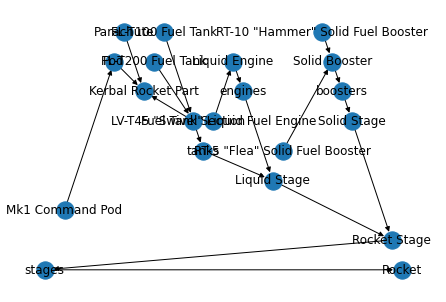

In [59]:
banded_feature_graph_labels = {}
for node in banded_feature_graph.nodes():
    banded_feature_graph_labels.update({node: get_name_by_id(node)})
    
NX.draw_planar(banded_feature_graph, labels=banded_feature_graph_labels)

In [60]:
part_leaves = [id_memo_dict[node]
    for node in part_featuring_graph.nodes
        if part_featuring_graph.in_degree(node) == 0]

In [61]:
part_roots = [id_memo_dict[node]
    for node in part_featuring_graph.nodes
        if part_featuring_graph.out_degree(node) == 0]

In [62]:
banded_roots = [id_memo_dict[node]
    for node in banded_feature_graph.nodes
        if banded_feature_graph.out_degree(node) == 0]

In [63]:
[part_leaf['name'] for part_leaf in part_leaves]

['stages', 'tanks', 'engines', 'boosters']

In [64]:
[part_root['name'] for part_root in part_roots]

['Rocket', 'Liquid Stage', 'Solid Stage']

In [65]:
[banded_root['name'] for banded_root in banded_roots]

['Rocket', 'Kerbal Rocket Part']

In [66]:
root_test = NX.shortest_path(part_featuring_graph, part_leaves[0]['@id'], part_roots[0]['@id'])

In [67]:
[feature_upper_multiplicity(id_memo_dict[node]) for node in root_test]

[5, 1]

Correct the multiplicities by considering nesting.part_uses

In [68]:
part_multiplicity = {}

for part_use in part_uses:
    corrected_mult = 0
    for part_tree_root in banded_roots:
        try:
            part_path = NX.shortest_path(banded_feature_graph, part_use['@id'], part_tree_root['@id'])
            # TODO: check that the path actually exists
            corrected_mult = math.prod([feature_upper_multiplicity(id_memo_dict[node]) for node in part_path])
        except NX.NetworkXNoPath:
            pass
    part_multiplicity.update({part_use['@id']: corrected_mult})

In [69]:
part_multiplicity

{'31a4436f-07fd-48c6-b503-9d186d925c3c': 5,
 '41c2ff4b-b7ac-4b42-9e23-b64db4fb1d40': 150,
 '54c2e565-ede4-4c12-a44c-2277566a2861': 40,
 '8c2b3ab7-9088-41b9-9ed5-f48bf60495e2': 40}

### Subdivide Abstract Feature Types

Look at the feature types for where they are abstract and then generate instances from the more specific types.

In [70]:
[get_name_by_id(node) for node in subclassing_graph.nodes if subclassing_graph.out_degree(node) == 0]

['Mk1 Command Pod',
 'Liquid Stage',
 'FL-T200 Fuel Tank',
 'RT-5 "Flea" Solid Fuel Booster',
 'FL-T100 Fuel Tank',
 'RT-10 "Hammer" Solid Fuel Booster',
 'Solid Stage',
 'LV-T45 "Swivel" Liquid Fuel Engine',
 'Parachute']

In [71]:
corrected_multiplicity_dict = {}
type_id_pairs = {}

for part_use in part_uses:
    type_name = get_feature_type_name(part_use)
    if type_name in corrected_multiplicity_dict:
        old_val = corrected_multiplicity_dict[part_use]
        corrected_multiplicity_dict.update({type_name: old_val + part_multiplicity[part_use['@id']]})
    else:
        corrected_multiplicity_dict.update({type_name: part_multiplicity[part_use['@id']]})
        if len(part_use['type']) > 0:
            type_id_pairs.update({type_name: part_use['type'][0]['@id']})

In [72]:
type_id_pairs

{'Rocket Stage': '83ad1765-fa32-41b1-bd41-90cb5cb2f9cc',
 'Fuel Tank Section': '2aa06d12-e2f5-4216-9766-05fdd165856e',
 'Solid Booster': '1aa22fbc-7b98-49dd-9164-e997b4f60f56',
 'Liquid Engine': '0fdf0feb-0557-45b1-8e54-1fb058d2325a'}

In [73]:
corrected_multiplicity_dict

{'Rocket Stage': 5,
 'Fuel Tank Section': 150,
 'Solid Booster': 40,
 'Liquid Engine': 40}

## Generate Random Alternatives

Start creating the alternatives with random draws on multiplicity. This will be our space for investigation for weights, thrust-to-weight ratios at stage ignitions, delta-Vs, and initial and burnout masses.

In [74]:
no_alts_to_create = 50

In [75]:
partitioned_multiplicity_dicts = []

for step in range(0, no_alts_to_create):

    partitioned_multiplicity_dict = {}

    for key in corrected_multiplicity_dict:
        if key in type_id_pairs:
            key_id = type_id_pairs[key]
            type_obj = id_memo_dict[key_id]
            if type_obj['isAbstract']:
                local_partition = {}
                if key_id in subclassing_graph.nodes:
                    no_splits = len(list(subclassing_graph.successors(key_id)))
                    taken = 0
                    for indx, succ in enumerate(subclassing_graph.successors(key_id)):
                        if indx < no_splits - 1:
                            draw = random.randint(0, corrected_multiplicity_dict[key])
                            taken = taken + draw
                        else:
                            draw = corrected_multiplicity_dict[key] - taken
                        local_partition.update({get_name_by_id(succ): draw})
                partitioned_multiplicity_dict.update({key: local_partition})
            else:
                partitioned_multiplicity_dict.update({key: corrected_multiplicity_dict[key]})
                
    partitioned_multiplicity_dicts.append(partitioned_multiplicity_dict)

In [76]:
partitioned_multiplicity_dicts[0]

{'Rocket Stage': {'Liquid Stage': 0, 'Solid Stage': 5},
 'Fuel Tank Section': {'FL-T200 Fuel Tank': 80, 'FL-T100 Fuel Tank': 70},
 'Solid Booster': {'RT-5 "Flea" Solid Fuel Booster': 6,
  'RT-10 "Hammer" Solid Fuel Booster': 34},
 'Liquid Engine': {'LV-T45 "Swivel" Liquid Fuel Engine': 40}}

- [ ] TODO: Fix the dictionary to have keys as IDs, not name

In [77]:
classifier_instance_dicts = []
classifier_memo_dicts = []

for step in range(0, no_alts_to_create):

    classifier_instance_dict = {}
    classifier_memo_dict = {}
    
    partitioned_multiplicity_dict = partitioned_multiplicity_dicts[step]

    for mult_key in partitioned_multiplicity_dict:
        instances_list = []
        if isinstance(partitioned_multiplicity_dict[mult_key], dict):
            for special_key in partitioned_multiplicity_dict[mult_key]:
                sub_instances_list = []
                instances_number = (partitioned_multiplicity_dict[mult_key][special_key] + 1)
                for index in range(1, instances_number):
                    new_instance = Instance(special_key, index)
                    instances_list.append(new_instance)
                    sub_instances_list.append(new_instance)
                    classifier_memo_dict.update({new_instance.name: [special_key, mult_key]})
                classifier_instance_dict.update({special_key: sub_instances_list})
            classifier_instance_dict.update({mult_key: instances_list})
        else:
            instances_number = (corrected_multiplicity_dict[mult_key] + 1)
            for index in range(1, instances_number):
                new_instance = Instance(mult_key, index)
                instances_list.append(new_instance)
                classifier_memo_dict.update({new_instance.name: [mult_key]})
            classifier_instance_dict.update({mult_key: instances_list})
            
    classifier_instance_dicts.append(classifier_instance_dict)
    classifier_memo_dicts.append(classifier_memo_dict)

In [78]:
classifier_instance_dicts[0]

{'Liquid Stage': [],
 'Solid Stage': [SS#1, SS#2, SS#3, SS#4, SS#5],
 'Rocket Stage': [SS#1, SS#2, SS#3, SS#4, SS#5],
 'FL-T200 Fuel Tank': [FL-T200#1,
  FL-T200#2,
  FL-T200#3,
  FL-T200#4,
  FL-T200#5,
  FL-T200#6,
  FL-T200#7,
  FL-T200#8,
  FL-T200#9,
  FL-T200#10,
  FL-T200#11,
  FL-T200#12,
  FL-T200#13,
  FL-T200#14,
  FL-T200#15,
  FL-T200#16,
  FL-T200#17,
  FL-T200#18,
  FL-T200#19,
  FL-T200#20,
  FL-T200#21,
  FL-T200#22,
  FL-T200#23,
  FL-T200#24,
  FL-T200#25,
  FL-T200#26,
  FL-T200#27,
  FL-T200#28,
  FL-T200#29,
  FL-T200#30,
  FL-T200#31,
  FL-T200#32,
  FL-T200#33,
  FL-T200#34,
  FL-T200#35,
  FL-T200#36,
  FL-T200#37,
  FL-T200#38,
  FL-T200#39,
  FL-T200#40,
  FL-T200#41,
  FL-T200#42,
  FL-T200#43,
  FL-T200#44,
  FL-T200#45,
  FL-T200#46,
  FL-T200#47,
  FL-T200#48,
  FL-T200#49,
  FL-T200#50,
  FL-T200#51,
  FL-T200#52,
  FL-T200#53,
  FL-T200#54,
  FL-T200#55,
  FL-T200#56,
  FL-T200#57,
  FL-T200#58,
  FL-T200#59,
  FL-T200#60,
  FL-T200#61,
  FL-T200#62,
  

Now that the universe of instances has been calculated, we can look at how they can be sequenced. This method is probably fragile so will need revisions.
In this case, found that it can't handle unconnected featuring graph components.

In [79]:
[get_name_by_id(node) for node in NX.topological_sort(part_featuring_graph.reverse())]

['Solid Stage',
 'boosters',
 'Liquid Stage',
 'engines',
 'tanks',
 'Rocket',
 'stages']

In [80]:
sorted_feature_groups = []

In [81]:
for comp in NX.connected_components(part_featuring_graph.to_undirected()):
    connected_sub = NX.subgraph(part_featuring_graph, list(comp))
    sorted_feature_groups.append(
        [node for node in NX.topological_sort(connected_sub.reverse())]
    )
    print([get_name_by_id(node) for node in NX.topological_sort(connected_sub.reverse())])

['Rocket', 'stages']
['Liquid Stage', 'tanks', 'engines']
['Solid Stage', 'boosters']


In [82]:
sorted_feature_groups

[['005e77f7-9600-4b89-ac1b-9274377e6599',
  '31a4436f-07fd-48c6-b503-9d186d925c3c'],
 ['b956c80a-60de-417e-9057-b558bc65371a',
  '41c2ff4b-b7ac-4b42-9e23-b64db4fb1d40',
  '8c2b3ab7-9088-41b9-9ed5-f48bf60495e2'],
 ['9889e62f-cbea-4412-a67f-f4a8b1f871d0',
  '54c2e565-ede4-4c12-a44c-2277566a2861']]

In [83]:
classifier_instance_dicts[0]

{'Liquid Stage': [],
 'Solid Stage': [SS#1, SS#2, SS#3, SS#4, SS#5],
 'Rocket Stage': [SS#1, SS#2, SS#3, SS#4, SS#5],
 'FL-T200 Fuel Tank': [FL-T200#1,
  FL-T200#2,
  FL-T200#3,
  FL-T200#4,
  FL-T200#5,
  FL-T200#6,
  FL-T200#7,
  FL-T200#8,
  FL-T200#9,
  FL-T200#10,
  FL-T200#11,
  FL-T200#12,
  FL-T200#13,
  FL-T200#14,
  FL-T200#15,
  FL-T200#16,
  FL-T200#17,
  FL-T200#18,
  FL-T200#19,
  FL-T200#20,
  FL-T200#21,
  FL-T200#22,
  FL-T200#23,
  FL-T200#24,
  FL-T200#25,
  FL-T200#26,
  FL-T200#27,
  FL-T200#28,
  FL-T200#29,
  FL-T200#30,
  FL-T200#31,
  FL-T200#32,
  FL-T200#33,
  FL-T200#34,
  FL-T200#35,
  FL-T200#36,
  FL-T200#37,
  FL-T200#38,
  FL-T200#39,
  FL-T200#40,
  FL-T200#41,
  FL-T200#42,
  FL-T200#43,
  FL-T200#44,
  FL-T200#45,
  FL-T200#46,
  FL-T200#47,
  FL-T200#48,
  FL-T200#49,
  FL-T200#50,
  FL-T200#51,
  FL-T200#52,
  FL-T200#53,
  FL-T200#54,
  FL-T200#55,
  FL-T200#56,
  FL-T200#57,
  FL-T200#58,
  FL-T200#59,
  FL-T200#60,
  FL-T200#61,
  FL-T200#62,
  

In [84]:
for classifier_instance_dict in classifier_instance_dicts:

    for part_tree_root in part_roots:
        root_name = get_name_by_id(part_tree_root['@id'])
        if root_name not in classifier_instance_dict:
            classifier_instance_dict.update({root_name: Instance(root_name, 1)})

The topological sort on the graph of feature membership determines the order in which to build up sets of instances for features.

In [85]:
classifier_instance_dicts[0]

{'Liquid Stage': [],
 'Solid Stage': [SS#1, SS#2, SS#3, SS#4, SS#5],
 'Rocket Stage': [SS#1, SS#2, SS#3, SS#4, SS#5],
 'FL-T200 Fuel Tank': [FL-T200#1,
  FL-T200#2,
  FL-T200#3,
  FL-T200#4,
  FL-T200#5,
  FL-T200#6,
  FL-T200#7,
  FL-T200#8,
  FL-T200#9,
  FL-T200#10,
  FL-T200#11,
  FL-T200#12,
  FL-T200#13,
  FL-T200#14,
  FL-T200#15,
  FL-T200#16,
  FL-T200#17,
  FL-T200#18,
  FL-T200#19,
  FL-T200#20,
  FL-T200#21,
  FL-T200#22,
  FL-T200#23,
  FL-T200#24,
  FL-T200#25,
  FL-T200#26,
  FL-T200#27,
  FL-T200#28,
  FL-T200#29,
  FL-T200#30,
  FL-T200#31,
  FL-T200#32,
  FL-T200#33,
  FL-T200#34,
  FL-T200#35,
  FL-T200#36,
  FL-T200#37,
  FL-T200#38,
  FL-T200#39,
  FL-T200#40,
  FL-T200#41,
  FL-T200#42,
  FL-T200#43,
  FL-T200#44,
  FL-T200#45,
  FL-T200#46,
  FL-T200#47,
  FL-T200#48,
  FL-T200#49,
  FL-T200#50,
  FL-T200#51,
  FL-T200#52,
  FL-T200#53,
  FL-T200#54,
  FL-T200#55,
  FL-T200#56,
  FL-T200#57,
  FL-T200#58,
  FL-T200#59,
  FL-T200#60,
  FL-T200#61,
  FL-T200#62,
  

In [103]:
feature_sequence_dictionaries = []

for step in range(0, no_alts_to_create):
    
    classifier_instance_dict = classifier_instance_dicts[step]
    
    feature_sequence_dictionary = {}
    covered_draw_dict = {}
    
    for sorting in sorted_feature_groups:
        for indx, node in enumerate(sorting):
            if indx > 0:
                new_dict = {}
                # get current parent from the graph
                for pred in part_featuring_graph.successors(node):
                    current_parent = pred
                    #print(get_name_by_id(current_parent))

                sequence_of_sequences = []

                for sequence in feature_sequence_dictionary[current_parent]:

                    test_mult = random.randint(
                        feature_lower_multiplicity(id_memo_dict[node]),
                        feature_upper_multiplicity(id_memo_dict[node])
                    )

                    for ind_j in range(0, test_mult):
                        new_sequence = copy.deepcopy(sequence)
                        # find the type of the current feature node
                        node_type = get_feature_type_name(id_memo_dict[node])

                        need_draw = True
                        
                        safety_count = 0

                        while(need_draw and safety_count < 100):

                            draw = random.randint(
                                0,
                                corrected_multiplicity_dict[node_type] - 1
                            )
                            #print(classifier_instance_dict[node_type][draw])

                            if node_type in covered_draw_dict:
                                if classifier_instance_dict[node_type][draw] in covered_draw_dict[node_type]:
                                    pass
                                    #need_draw = False
                                else:
                                    covered_draw_dict[node_type].append(classifier_instance_dict[node_type][draw])
                                    need_draw = False
                            else:
                                covered_draw_dict.update({node_type : [classifier_instance_dict[node_type][draw]]})
                                need_draw = False

                            safety_count = safety_count + 1
                            if safety_count == 99:
                                print('Safety count hit when trying to place ' + 
                                      str(classifier_instance_dict[node_type][draw]) + ' under ' +
                                     str(new_sequence))
                                print('Covered dict is ' + str(covered_draw_dict[node_type]))
                        
                        new_sequence.append(classifier_instance_dict[node_type][draw])

                        sequence_of_sequences.append(new_sequence)

                feature_sequence_dictionary.update({node: sequence_of_sequences})

            elif indx == 0:
                if isinstance(classifier_instance_dict[get_name_by_id(node)], list):
                    starter_list = []
                    for item in classifier_instance_dict[get_name_by_id(node)]:
                        starter_list.append([item])
                    # handle case where main type has more than one instance
                    feature_sequence_dictionary.update({node: starter_list})
                    #print(starter_list)
                    if len(starter_list) == 0:
                        break
                else:
                    feature_sequence_dictionary.update({node: [[classifier_instance_dict[get_name_by_id(node)]]]})
            
    feature_sequence_dictionaries.append(feature_sequence_dictionary)

In [104]:
covered_draw_dict

{'Rocket Stage': [LS#1],
 'Fuel Tank Section': [FL-T100#58,
  FL-T100#108,
  FL-T100#33,
  FL-T200#24,
  FL-T100#116,
  FL-T100#88,
  FL-T100#35,
  FL-T100#27,
  FL-T200#27,
  FL-T100#73,
  FL-T100#105,
  FL-T100#2,
  FL-T100#85,
  FL-T100#86,
  FL-T100#45,
  FL-T100#46,
  FL-T100#50,
  FL-T100#25,
  FL-T100#34,
  FL-T200#21,
  FL-T100#66,
  FL-T100#53,
  FL-T200#7,
  FL-T100#87,
  FL-T100#110,
  FL-T100#107,
  FL-T100#41,
  FL-T200#1,
  FL-T100#95,
  FL-T100#82,
  FL-T100#11,
  FL-T100#38,
  FL-T100#74,
  FL-T200#29,
  FL-T200#11,
  FL-T100#26,
  FL-T100#23,
  FL-T100#56,
  FL-T100#40,
  FL-T200#6,
  FL-T200#22,
  FL-T100#97,
  FL-T100#14,
  FL-T100#32,
  FL-T100#5,
  FL-T200#17,
  FL-T100#78,
  FL-T200#18,
  FL-T100#99,
  FL-T100#51,
  FL-T100#79,
  FL-T100#48,
  FL-T100#47,
  FL-T100#118,
  FL-T200#5,
  FL-T100#112,
  FL-T100#54,
  FL-T100#75,
  FL-T100#70,
  FL-T100#22],
 'Liquid Engine': [LV-T45#22,
  LV-T45#21,
  LV-T45#7,
  LV-T45#25,
  LV-T45#34,
  LV-T45#18,
  LV-T45#20,
  LV-

In [105]:
for indx, feature_sequence_dictionary in enumerate(feature_sequence_dictionaries):
    if indx < 3:
        print("Solution #" + str(indx))
        for key in feature_sequence_dictionary:
            print(get_name_by_id(key) + ', id ' + key)
            for seq in feature_sequence_dictionary[key]:
                print(str(seq))

Solution #0
Rocket, id 005e77f7-9600-4b89-ac1b-9274377e6599
[Rocket#1]
stages, id 31a4436f-07fd-48c6-b503-9d186d925c3c
[Rocket#1, SS#5]
Liquid Stage, id b956c80a-60de-417e-9057-b558bc65371a
Solid Stage, id 9889e62f-cbea-4412-a67f-f4a8b1f871d0
[SS#1]
[SS#2]
[SS#3]
[SS#4]
[SS#5]
boosters, id 54c2e565-ede4-4c12-a44c-2277566a2861
[SS#1, RT-10#7]
[SS#1, RT-5#1]
[SS#2, RT-10#17]
[SS#2, RT-10#15]
[SS#2, RT-10#1]
[SS#2, RT-5#2]
[SS#4, RT-10#9]
[SS#4, RT-10#18]
[SS#4, RT-10#10]
[SS#4, RT-10#32]
[SS#4, RT-10#33]
[SS#4, RT-10#14]
[SS#4, RT-10#5]
[SS#5, RT-10#8]
[SS#5, RT-10#21]
[SS#5, RT-10#16]
[SS#5, RT-10#26]
[SS#5, RT-5#3]
[SS#5, RT-5#6]
Solution #1
Rocket, id 005e77f7-9600-4b89-ac1b-9274377e6599
[Rocket#1]
stages, id 31a4436f-07fd-48c6-b503-9d186d925c3c
[Rocket#1, SS#1]
[Rocket#1, SS#2]
[Rocket#1, LS#2]
[Rocket#1, LS#1]
[Rocket#1, LS#3]
Liquid Stage, id b956c80a-60de-417e-9057-b558bc65371a
[LS#1]
[LS#2]
[LS#3]
tanks, id 41c2ff4b-b7ac-4b42-9e23-b64db4fb1d40
[LS#1, FL-T100#18]
[LS#1, FL-T100#3]

# Analyze and Explore Resulting Space

Now that the alternatives have been generated, we can explore the population

In [106]:
[[get_name_by_id(node), node] for node in subclassing_graph.nodes if subclassing_graph.out_degree(node) == 0]

[['Mk1 Command Pod', '268c72eb-0f0c-4543-9bb9-1dae49c51dfa'],
 ['Liquid Stage', 'b956c80a-60de-417e-9057-b558bc65371a'],
 ['FL-T200 Fuel Tank', '1183b678-fbfd-4a6e-8ae3-3ef8bf13b652'],
 ['RT-5 "Flea" Solid Fuel Booster', '16689b2f-073c-4e3c-8b2d-379a32e71cf6'],
 ['FL-T100 Fuel Tank', '0663d6ae-8ecb-4825-ad65-327bc333aa01'],
 ['RT-10 "Hammer" Solid Fuel Booster', 'a77efc12-e695-4680-bd2e-694d3655bb8c'],
 ['Solid Stage', '9889e62f-cbea-4412-a67f-f4a8b1f871d0'],
 ['LV-T45 "Swivel" Liquid Fuel Engine',
  '62b7c441-2b36-4fec-b70a-c6f659280252'],
 ['Parachute', 'e8a35029-431c-45ff-9a14-5bf0c32f5e7e']]

## Gather AttributeUsages and literal values

Find all the attribute usages so we can navigate to them from our parts library.

In [107]:
att_uses = [att_use for att_use in non_relations if att_use['@type'] == 'AttributeUsage']
for att_use in att_uses:
    id_memo_dict.update({att_use['@id']: att_use})

In [108]:
reals = [real for real in non_relations if real['@type'] == 'LiteralReal']
for real in reals:
    id_memo_dict.update({real['@id']: real})

In [109]:
type_values = {}

for att_use in att_uses:
    if len(att_use['ownedMember']) > 0:
        typ = id_memo_dict[att_use['owningType']['@id']]
        for att_member in att_use['ownedMember']:
            value = id_memo_dict[att_member['@id']]['value']
            print (att_use['name'] + ' of ' + typ['name'] + ' = ' + str(value))
            if att_use['name'] in type_values:
                type_values[att_use['name']].update({typ['name']: value})
            else:
                type_values.update({att_use['name']: {typ['name']: value}})

Full Mass of RT-5 "Flea" Solid Fuel Booster = 1.5
Empty Mass of FL-T100 Fuel Tank = 0.0625
Thrust of RT-10 "Hammer" Solid Fuel Booster = 197.9
Specific Impulse of RT-5 "Flea" Solid Fuel Booster = 140.0
Thrust of RT-5 "Flea" Solid Fuel Booster = 162.91
Empty Mass of RT-10 "Hammer" Solid Fuel Booster = 0.75
Specific Impulse of LV-T45 "Swivel" Liquid Fuel Engine = 170.0
Specific Impulse of RT-10 "Hammer" Solid Fuel Booster = 170.0
Thrust of LV-T45 "Swivel" Liquid Fuel Engine = 167.97
Empty Mass of RT-5 "Flea" Solid Fuel Booster = 0.45
Full Mass of RT-10 "Hammer" Solid Fuel Booster = 3.56
Full Mass of FL-T200 Fuel Tank = 1.125
Full Mass of FL-T100 Fuel Tank = 0.5625
Empty Mass of FL-T200 Fuel Tank = 0.125


In [110]:
type_values

{'Full Mass': {'RT-5 "Flea" Solid Fuel Booster': 1.5,
  'RT-10 "Hammer" Solid Fuel Booster': 3.56,
  'FL-T200 Fuel Tank': 1.125,
  'FL-T100 Fuel Tank': 0.5625},
 'Empty Mass': {'FL-T100 Fuel Tank': 0.0625,
  'RT-10 "Hammer" Solid Fuel Booster': 0.75,
  'RT-5 "Flea" Solid Fuel Booster': 0.45,
  'FL-T200 Fuel Tank': 0.125},
 'Thrust': {'RT-10 "Hammer" Solid Fuel Booster': 197.9,
  'RT-5 "Flea" Solid Fuel Booster': 162.91,
  'LV-T45 "Swivel" Liquid Fuel Engine': 167.97},
 'Specific Impulse': {'RT-5 "Flea" Solid Fuel Booster': 140.0,
  'LV-T45 "Swivel" Liquid Fuel Engine': 170.0,
  'RT-10 "Hammer" Solid Fuel Booster': 170.0}}

- [ ] TODO: Factor the above as sequences of instances rather than going back to the type

## Perform Staging Mass Analysis

- [ ] TODO: Strengthen this with analyses that actually do the calculation
- [ ] TODO: Accommodate associations between tanks and engines to make delta-V and Isp calculations work properly

This is very specific to a given calculation - need to have a kernel for expanding the calculations just as with inspecting type hierarchy and multiplicity

In [120]:
for indx, feature_sequence_dictionary in enumerate(feature_sequence_dictionaries):
    no_stages = len(feature_sequence_dictionary['31a4436f-07fd-48c6-b503-9d186d925c3c'])
    print(str(no_stages))
    for stag in range(1, no_stages + 1):
        stage_empty_mass = 0
        stage_full_mass = 0
        stage_specific_impulse = 0
        # add up the starter mass for the stage and the burnout mass
        stage_instance = feature_sequence_dictionary['31a4436f-07fd-48c6-b503-9d186d925c3c'][stag - 1][-1]
        print(str(stage_instance) + ": " + str(classifier_memo_dicts[indx][stage_instance.name]))
        if '54c2e565-ede4-4c12-a44c-2277566a2861' in feature_sequence_dictionary:
            booster_instances = \
                [booster[-1] for booster in feature_sequence_dictionary['54c2e565-ede4-4c12-a44c-2277566a2861']
                     if str(booster[0]) == str(stage_instance)]
            print('Booster instance length = ' + str(len(booster_instances)))
            for booster in booster_instances:
                for clz in classifier_memo_dicts[indx][booster.name]:
                    if clz in partitioned_multiplicity_dicts[indx]:
                        pass
                    else:
                        empty_mass = type_values['Empty Mass'][clz]
                        full_mass = type_values['Full Mass'][clz]
                        specific_impulse = type_values['Specific Impulse'][clz]

                        stage_empty_mass = stage_empty_mass + empty_mass
                        stage_full_mass = stage_full_mass + full_mass
                        stage_specific_impulse = stage_specific_impulse + specific_impulse
            if len(booster_instances) > 0:
                stage_specific_impulse = stage_specific_impulse / len(booster_instances)
        
        if stage_empty_mass > 0.0:
            booster_delta_V = 9.81 * stage_specific_impulse * math.log(stage_full_mass / stage_empty_mass)
        
        print ('Stage booster full mass is ' + str(stage_full_mass))
        print ('Stage booster empty mass is ' + str(stage_empty_mass))
        print ('Stage booster specific impulse is ' + str(stage_specific_impulse))
        print ('Stage booster delta-V is ' + str(booster_delta_V))

1
SS#5: ['Solid Stage', 'Rocket Stage']
Booster instance length = 6
Stage booster full mass is 17.240000000000002
Stage booster empty mass is 3.9000000000000004
Stage booster specific impulse is 160.0
Stage booster delta-V is 2332.8269657120763
5
SS#1: ['Solid Stage', 'Rocket Stage']
Booster instance length = 8
Stage booster full mass is 22.3
Stage booster empty mass is 5.1000000000000005
Stage booster specific impulse is 158.75
Stage booster delta-V is 2297.611867333453
SS#2: ['Solid Stage', 'Rocket Stage']
Booster instance length = 0
Stage booster full mass is 0
Stage booster empty mass is 0
Stage booster specific impulse is 0
Stage booster delta-V is 2297.611867333453
LS#2: ['Liquid Stage', 'Rocket Stage']
Booster instance length = 0
Stage booster full mass is 0
Stage booster empty mass is 0
Stage booster specific impulse is 0
Stage booster delta-V is 2297.611867333453
LS#1: ['Liquid Stage', 'Rocket Stage']
Booster instance length = 0
Stage booster full mass is 0
Stage booster empty

In [ ]:
classifier_memo_dicts[21]